In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

In [2]:
raw_data = pd.read_csv('car_sales.csv')
df = raw_data.copy()

#### Dropping Model column and null records

In [3]:
df = df.drop(columns='Model')
df = df.dropna(axis=0)

In [4]:
df.describe()

,Price,Mileage,EngineV,Year
count,4025.000000,4025.000000,4025.000000,4025.000000
mean,19552.308065,163.572174,2.764586,2006.379627
std,25815.734988,103.394703,4.935941,6.695595
min,600.000000,0.000000,0.600000,1969.000000
25%,6999.000000,90.000000,1.800000,2003.000000
50%,11500.000000,158.000000,2.200000,2007.000000
75%,21900.000000,230.000000,3.000000,2012.000000
max,300000.000000,980.000000,99.990000,2016.000000


#### Handling Outliers

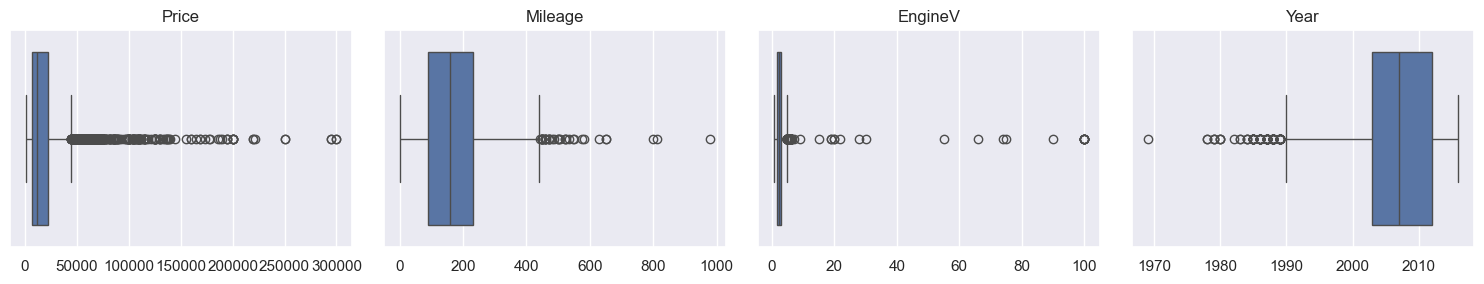

In [5]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

plt.subplots(1,4,figsize=(15,3))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(x=df[column])
    plt.title(column)
    plt.xlabel('')

plt.tight_layout()
plt.show()

In [6]:
df_outliers = df.copy()

In [7]:
enginevuqr = df['EngineV'].quantile(.75)
enginevuqr

3.0

#### Reasoning for outliers

###### Price
Clearly the data includes some top-end cars, or some erroneous data. While it's not impossible that cars are being sold for $300,000, it seems less likely to be included in used car sales (although, having never bought, sold, or owned a luxury sports car, it's hard for me to say... do people just take these to local dealer when they've had their fun? It seems unlikely).

Will drop under 200k and log transform to stabilise variance.

###### Mileage
Average mileage per year in the UK is around 6,000 miles. I'd imagine this is higher in the US, so looking at the means from the data, an average mileage per year of around 8,500 miles is found. So, the scale is x1000. Again, it wouldn't be impossible for a 30yo car to do 1 million miles, but research shows that around 300,000 is seen as a very impressive milestone to reach, requiring proper care and maintenance to reach.

Apply cap at 500k.

###### EngineV
The Upper quartile range is exactly 3 here, engines above this size are less common, in the UK at least, but can easily get much higher.

Apply cap at 7.

##### Year
There are few outliers on the lower end of the data, so I'd feel comfortable using IQR here. Either they're classic cars with a higher value, which will distort the data, or they're just very old cars.

#### Price

In [8]:
df_outliers = df_outliers[df_outliers['Price'] <= 200000]

In [9]:
df_outliers.describe()

,Price,Mileage,EngineV,Year
count,4016.000000,4016.000000,4016.000000,4016.000000
mean,19010.518167,163.880229,2.757809,2006.364293
std,23108.950597,103.300955,4.939352,6.694509
min,600.000000,0.000000,0.600000,1969.000000
25%,6999.000000,90.000000,1.800000,2003.000000
50%,11500.000000,158.500000,2.200000,2007.000000
75%,21700.000000,230.000000,3.000000,2012.000000
max,200000.000000,980.000000,99.990000,2016.000000


#### Mileage

In [10]:
df_outliers = df_outliers[df_outliers['Mileage'] <= 500]

In [11]:
df_outliers.describe()

,Price,Mileage,EngineV,Year
count,4000.00000,4000.000000,4000.000000,4000.000000
mean,19033.08524,162.064750,2.759490,2006.390500
std,23124.48087,99.082001,4.948941,6.676425
min,600.00000,0.000000,0.600000,1969.000000
25%,6999.75000,90.000000,1.800000,2003.000000
50%,11500.00000,158.000000,2.200000,2007.500000
75%,21700.00000,230.000000,3.000000,2012.000000
max,200000.00000,500.000000,99.990000,2016.000000


#### EngineV

In [12]:
df_outliers = df_outliers[df_outliers['EngineV'] <= 7]

In [13]:
df_outliers.describe()

,Price,Mileage,EngineV,Year
count,3978.000000,3978.000000,3978.000000,3978.000000
mean,19097.339105,161.866264,2.460742,2006.406737
std,23169.081300,99.127441,0.964430,6.675983
min,600.000000,0.000000,0.600000,1969.000000
25%,7000.000000,90.000000,1.800000,2003.000000
50%,11500.000000,157.000000,2.200000,2008.000000
75%,21875.000000,230.000000,3.000000,2012.000000
max,200000.000000,500.000000,6.500000,2016.000000


#### Year

In [14]:
df_year = df_outliers.copy()

q1 = df_year['Year'].quantile(.25)
q3 = df_year['Year'].quantile(.75)

IQR = q3 - q1

df_year = df_year[df_year['Year'] >= q1 - 1.5 * IQR]

In [15]:
df_year.describe()

,Price,Mileage,EngineV,Year
count,3881.000000,3881.000000,3881.000000,3881.000000
mean,19498.770964,160.040196,2.472077,2006.911878
std,23308.938316,97.476806,0.969875,5.912460
min,800.000000,0.000000,0.600000,1990.000000
25%,7300.000000,90.000000,1.800000,2003.000000
50%,11800.000000,156.000000,2.200000,2008.000000
75%,22000.000000,225.000000,3.000000,2012.000000
max,200000.000000,500.000000,6.500000,2016.000000


In [16]:
df_year.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011


In [17]:
df_year.reset_index(drop=True)

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011
...,...,...,...,...,...,...,...,...
3876,Volkswagen,11500.0,van,163,2.5,Diesel,yes,2008
3877,Toyota,17900.0,sedan,35,1.6,Petrol,yes,2014
3878,Mercedes-Benz,125000.0,sedan,9,3.0,Diesel,yes,2014
3879,BMW,6500.0,sedan,1,3.5,Petrol,yes,1999


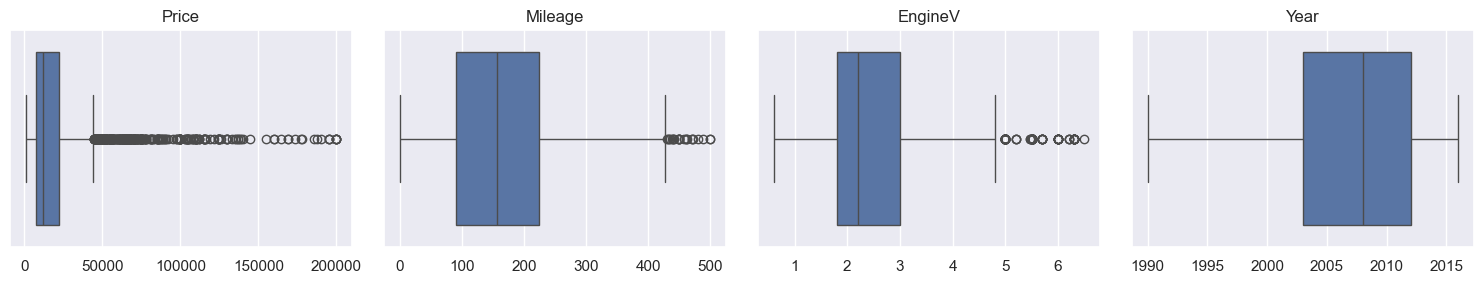

In [18]:
numerical_columns = df_year.select_dtypes(include=['float64', 'int64']).columns

plt.subplots(1,4,figsize=(15,3))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(x=df_year[column])
    plt.title(column)
    plt.xlabel('')

plt.tight_layout()
plt.show()

#### Evaluation

Boxplots look far better now, except for price, will check again for log_price

In [19]:
df = df_year.copy()

#### Checking OLS

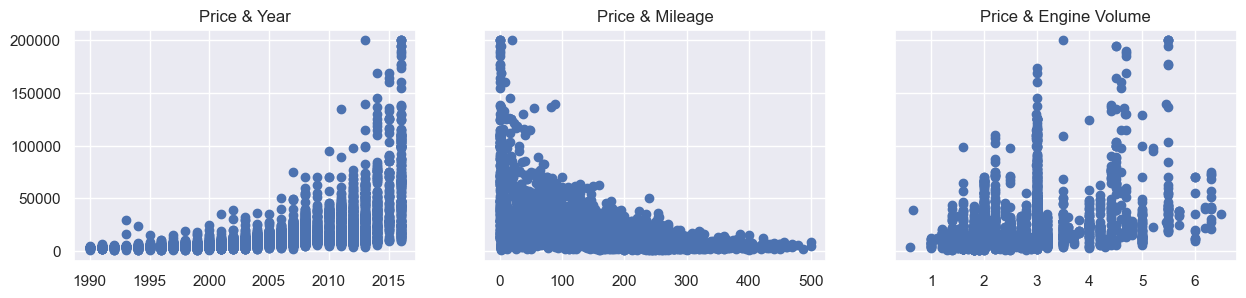

In [20]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True, figsize=(15,3))
ax1.scatter(df['Year'],df['Price'])
ax1.set_title('Price & Year')
ax2.scatter(df['Mileage'],df['Price'])
ax2.set_title('Price & Mileage')
ax3.scatter(df['EngineV'],df['Price'])
ax3.set_title('Price & Engine Volume')

plt.show()

In [21]:
log_price = np.log(df['Price'])
df['log_price'] = log_price
df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,log_price
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,8.342840
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,8.974618
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,9.495519
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,10.043249
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,9.814656


<Axes: xlabel='log_price'>

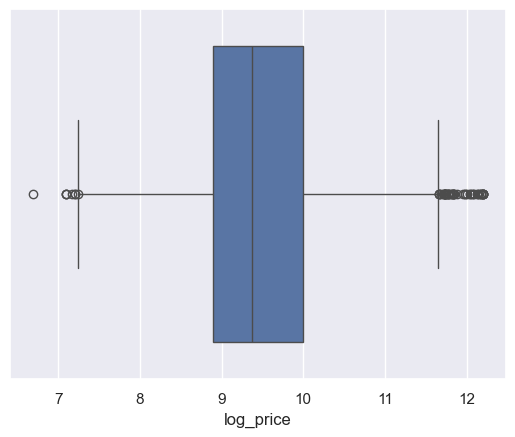

In [22]:
sns.boxplot(x=df['log_price'])

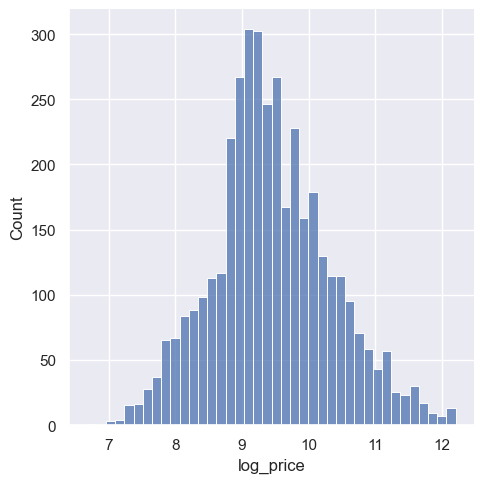

In [23]:
sns.displot(df['log_price'])

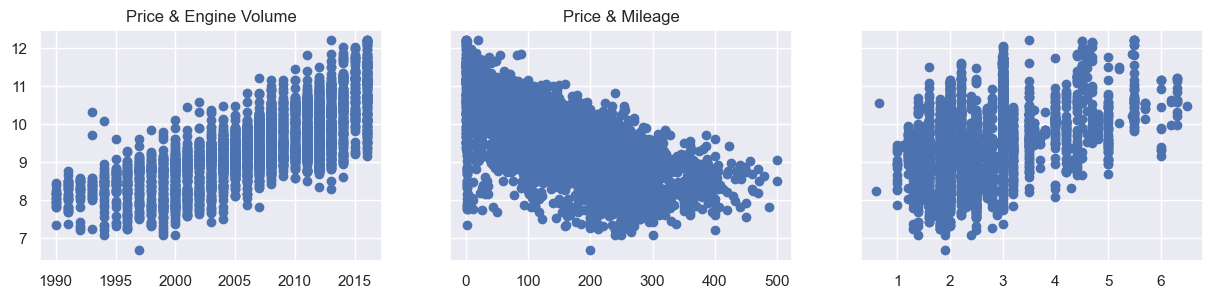

In [24]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True, figsize=(15,3))
ax1.scatter(df['Year'],df['log_price'])
ax1.set_title('Price & Year')
ax2.scatter(df['Mileage'],df['log_price'])
ax2.set_title('Price & Mileage')
ax3.scatter(df['EngineV'],df['log_price'])
ax1.set_title('Price & Engine Volume')

plt.show()

In [25]:
df_log = df.drop(columns='Price')

#### Checkpoint

Will probably make mistakes from here on out, so let's get some checkpoints going

In [26]:
df_dummy_check = df.copy()

#### Dummies

In [27]:
numerical = df.select_dtypes(include=['float64', 'int64'])
categorical = df.select_dtypes(include=['object','category'])

dummy = pd.concat([numerical, pd.get_dummies(categorical, drop_first=True).astype(int)], axis=1)
dummy.head()

,Price,Mileage,EngineV,Year,log_price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,4200.0,277,2.0,1991,8.342840,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,7900.0,427,2.9,1999,8.974618,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,13300.0,358,5.0,2003,9.495519,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,23000.0,240,4.2,2007,10.043249,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,18300.0,120,2.0,2011,9.814656,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


In [28]:
df = dummy.copy()

#### F-Reg

In [29]:
from sklearn.feature_selection import f_regression

In [30]:
df.columns

Index(['Price', 'Mileage', 'EngineV', 'Year', 'log_price', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes'],
      dtype='object')

In [31]:
df = df.drop(columns='Price')

In [32]:
targets = df['log_price']
features = df[['Mileage', 'EngineV', 'Year', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes']]

In [33]:
f_stats, p_stats = f_regression(features,targets)

In [34]:
freg_summary = pd.DataFrame(data=features.columns.values, columns=['Features'])

In [35]:
freg_summary['p_values'] = p_stats.round(3)

In [36]:
freg_summary

,Features,p_values
0,Mileage,0.000
1,EngineV,0.000
2,Year,0.000
3,Brand_BMW,0.000
4,Brand_Mercedes-Benz,0.000
5,Brand_Mitsubishi,0.000
6,Brand_Renault,0.000
7,Brand_Toyota,0.000
8,Brand_Volkswagen,0.000
9,Body_hatch,0.000


#### VIF Check

Clearly, we see some very high VIFs in the final model. However, these features carry some of the highest weights and lowest p-values and knowledge of cars tells us that mileage and year are not necessarily correlated (some of the mc with year may come from specific brands and engine sizes and when they were released/manufactured).

Additionally, registration of a vehicle is likely to carry a time and monetary cost that would well affect the final price, therefore its inclusion is valid.

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif['Features'] = features.columns
vif

,VIF,Features
0,4.663189,Mileage
1,12.001178,EngineV
2,44.188968,Year
3,2.620111,Brand_BMW
4,3.189111,Brand_Mercedes-Benz
5,1.952237,Brand_Mitsubishi
6,2.450522,Brand_Renault
7,2.495890,Brand_Toyota
8,3.461293,Brand_Volkswagen
9,1.666593,Body_hatch


#### Scaling

In [38]:
target = df['log_price']
features = df[['Mileage', 'EngineV', 'Year', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol','Registration_yes']]

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [40]:
scaler.fit(features)

StandardScaler()

In [41]:
features_scaled = scaler.transform(features)

#### TT Split

In [42]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features_scaled, targets, test_size=0.2, random_state=42)

#### Regression

In [43]:
reg = LinearRegression()

In [44]:
reg.fit(x_train, y_train)

LinearRegression()

In [45]:
r2 = reg.score(x_train,y_train)
n = x_train.shape[0]
p = x_train.shape[1]
r2

0.8827665816279174

In [46]:
r2adj = 1 - (1 - r2) * (n-1) / (n-p-1)
r2adj

0.8820825616827966

#### $R^2$-adj of 0.88 > 0.82

Succesful model adjustment

#### Benchmarks

In [47]:
df_bench = df.copy()

df.columns.values

array(['Mileage', 'EngineV', 'Year', 'log_price', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes'],
      dtype=object)

In [48]:
raw_data['Brand'].unique()

array(['BMW', 'Mercedes-Benz', 'Audi', 'Toyota', 'Renault', 'Volkswagen',
       'Mitsubishi'], dtype=object)

In [49]:
raw_data['Body'].unique()

array(['sedan', 'van', 'crossover', 'vagon', 'other', 'hatch'],
      dtype=object)

In [50]:
benchmarks = {'Brand':'Audi', 'Body':'crossover', 'Engine Type':'Diesel'}

In [52]:
y_hat = reg.predict(x_train)

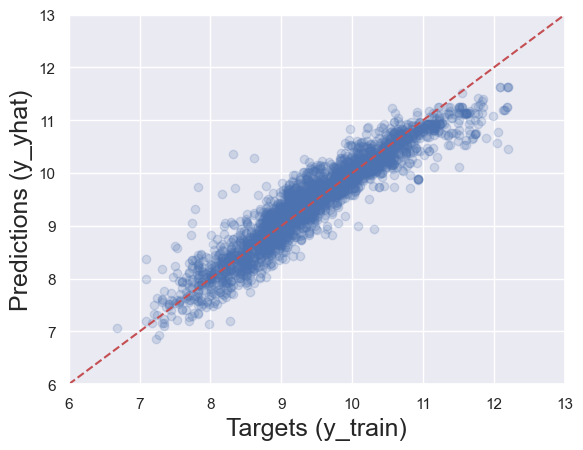

In [53]:
plt.scatter(y_train, y_hat, alpha=.2)
plt.xlabel('Targets (y_train)', size=18)
plt.ylabel('Predictions (y_yhat)', size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.plot([6, 13], [6, 13], 'r--')
plt.show()

Text(0.5, 1.0, 'Residuals PDF')

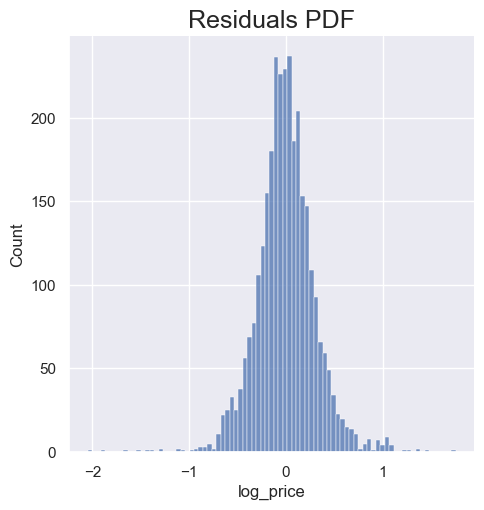

In [54]:
sns.displot(y_train - y_hat)
plt.title("Residuals PDF", size=18)

#### Result

Scatter: The under-prediction at the higher end remains. However, the 'mouth' seen previously at the bottom has entirely closed, suggesting the model is better able to predict the lower value vehicles.

Distribution: The skew remains roughly the same, but the distribution appears more normal, centred around 0.

#### Weight & Bias

Year and registration status carry the bulk of the weights in this model, once again validating their inclusion

In [56]:
reg_summary = pd.DataFrame(features.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,Mileage,-0.118495
1,EngineV,0.240574
2,Year,0.499545
3,Brand_BMW,0.024262
4,Brand_Mercedes-Benz,0.004997
5,Brand_Mitsubishi,-0.132847
6,Brand_Renault,-0.208773
7,Brand_Toyota,-0.080470
8,Brand_Volkswagen,-0.108606
9,Body_hatch,-0.087827


#### Testing

In [58]:
y_hat_test = reg.predict(x_test)

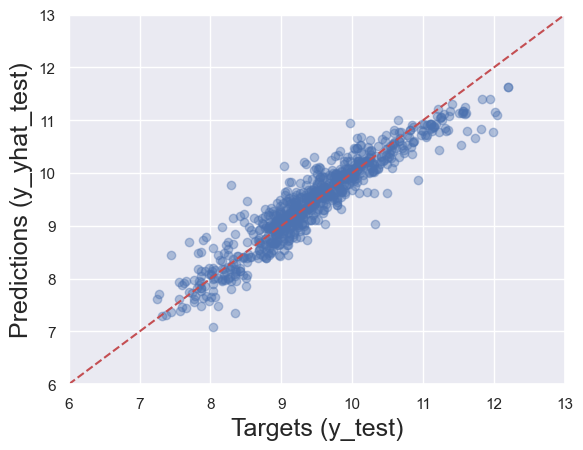

In [68]:
plt.scatter(y_test, y_hat_test, alpha=.4)
plt.xlabel('Targets (y_test)', size=18)
plt.ylabel('Predictions (y_yhat_test)', size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.plot([6, 13], [6, 13], 'r--')
plt.show()

In [60]:
df_pf = pd.DataFrame(np.exp(y_hat_test), columns = ['Predictions'])
df_pf.head()

,Predictions
0,8388.767876
1,24970.396974
2,2612.941061
3,10644.175595
4,6985.045149


In [61]:
y_test_ind = y_test.reset_index(drop=True)
y_test_ind.head()

0    9.210240
1    9.035987
2    7.919356
3    8.974618
4    8.961879
Name: log_price, dtype: float64

In [62]:
df_pf['Target'] = np.exp(y_test_ind)
df_pf

,Predictions,Target
0,8388.767876,9999.0
1,24970.396974,8400.0
2,2612.941061,2750.0
3,10644.175595,7900.0
4,6985.045149,7800.0
...,...,...
772,3416.041140,2750.0
773,10604.006740,6800.0
774,9763.722115,9200.0
775,7823.835865,8500.0


In [63]:
df_pf['Residuals'] = df_pf['Target'] - df_pf['Predictions']
df_pf

,Predictions,Target,Residuals
0,8388.767876,9999.0,1610.232124
1,24970.396974,8400.0,-16570.396974
2,2612.941061,2750.0,137.058939
3,10644.175595,7900.0,-2744.175595
4,6985.045149,7800.0,814.954851
...,...,...,...
772,3416.041140,2750.0,-666.041140
773,10604.006740,6800.0,-3804.006740
774,9763.722115,9200.0,-563.722115
775,7823.835865,8500.0,676.164135


In [64]:
df_pf['Residuals%'] = np.absolute(df_pf['Residuals']/df_pf['Target'] * 100)
df_pf

,Predictions,Target,Residuals,Residuals%
0,8388.767876,9999.0,1610.232124,16.103932
1,24970.396974,8400.0,-16570.396974,197.266631
2,2612.941061,2750.0,137.058939,4.983961
3,10644.175595,7900.0,-2744.175595,34.736400
4,6985.045149,7800.0,814.954851,10.448139
...,...,...,...,...
772,3416.041140,2750.0,-666.041140,24.219678
773,10604.006740,6800.0,-3804.006740,55.941276
774,9763.722115,9200.0,-563.722115,6.127414
775,7823.835865,8500.0,676.164135,7.954872


In [65]:
df_pf.describe()

,Predictions,Target,Residuals,Residuals%
count,777.000000,777.000000,777.000000,777.000000
mean,17954.421750,19802.697027,1848.275277,24.037435
std,15953.332520,24228.042600,11996.416727,26.897988
min,1183.266003,1400.000000,-35116.044717,0.079173
25%,7570.546805,7500.000000,-1927.950153,8.029479
50%,13144.326125,12300.000000,117.807287,17.669838
75%,22971.202363,21900.000000,2023.051003,30.004060
max,112009.207579,199999.000000,112375.155530,336.647776


In [66]:
pd.options.display.max_rows = 999
df_pf.sort_values(by=['Residuals%'])

,Predictions,Target,Residuals,Residuals%
638,8493.270335,8500.00,6.729665,0.079173
360,49568.343086,49500.00,-68.343086,0.138067
745,3594.040097,3600.00,5.959903,0.165553
188,23652.851046,23700.00,47.148954,0.198941
757,27834.562471,27900.00,65.437529,0.234543
467,15301.056723,15250.00,-51.056723,0.334798
642,49704.200690,49500.00,-204.200690,0.412527
776,9155.683156,9200.00,44.316844,0.481705
771,13967.450651,13900.00,-67.450651,0.485256
221,23382.192713,23500.00,117.807287,0.501308


#### Conclusion

Another solid improvement, with the mean residual% down almost another 10% and the maximum error dropping to 336% from 400$.

25% of predictions have a residual percentage of under 10% (8.03%), and 50% of predictions are under 20% (17.67%).

The underprediction of the model remains, however it is not solely focused on lower-priced vehicles, and instead includes vehicles up to and exceeding $10,000, suggesting that some of the low-end underprediction seen previously was indeed focused on the lower-priced vehicles.

In [69]:
r2 = reg.score(x_test,y_test)
n = x_test.shape[0]
p = x_test.shape[1]
r2

0.881940349331652

In [70]:
r2adj = 1 - (1 - r2) * (n-1) / (n-p-1)
r2adj

0.8791368220070738